#  1D Advection Equation

The one-dimensional advection equation describes the transport of a scalar quantity $u(x, t)$ at a constant velocity $ \alpha $:

\begin{equation}
\frac{\partial u}{\partial t} + \alpha \frac{\partial u}{\partial x} = 0
\end{equation}


It represents how a wave or distribution moves without distortion along the $x$ -axis at speed $ \alpha $. 


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
from IPython.display import Video
from scipy.interpolate import interp1d


In [155]:
# Parameters
L = 2.0          # Domain
alpha = 1.0      # advection velocity
N = 500          # number of space points
dx = 2*L / N       # spatial step
x = np.linspace(-L, L, N, endpoint=False)

# CFL
CFL = 0.5                           
dt = CFL * dx / abs(alpha)          # Time step
tf = 0.3                            # Final time
n_steps = int(tf / dt) + 1          # Total number of time steps

# Initial condition: Gaussian pulse 
u0 = np.exp(-100 * (x)**2)

In [156]:
# Runge-Kutta 4 Algorithm
def RK4(ODE, t0, q0, tf, n):
    dt = (tf - t0)/(n-1)
    q = np.zeros([n, len(q0)+1])
    q[0, 0] = t0
    q[0, 1:] = q0
    for i in range(1, n):
        q[i, 0] = q[i-1, 0] + dt
        k1 = dt * ODE(q[i-1, 0], q[i-1, 1:])
        k2 = dt * ODE(q[i-1, 0] + dt/2, q[i-1, 1:] + k1/2)
        k3 = dt * ODE(q[i-1, 0] + dt/2, q[i-1, 1:] + k2/2)
        k4 = dt * ODE(q[i-1, 0] + dt, q[i-1, 1:] + k3)
        q[i, 1:] = q[i-1, 1:] + (k1 + 2*k2 + 2*k3 + k4)/6
    return q

In [157]:
def du1dt(t, u):
    # Centered difference
    # du_i/dt = -α * (u_{i+1} - u_{i-1}) / (2Δx)
    return -alpha * (np.roll(u, -1) - np.roll(u, 1)) / (2 * dx)


In [158]:
def du2dt(t, u):
    # Forward difference
    # du_i/dt = -α * (u_{i+1} - u_i) / Δx
    return -alpha * (np.roll(u, -1) - u) / dx


In [159]:
def du3dt(t, u):
    # Backward difference
    # du_i/dt = -α * (u_i - u_{i-1}) / Δx
    return -alpha * (u - np.roll(u, 1)) / dx


In [160]:
def save_advection_animation_1D(x, u_array, t_array, filename="advection_1D.gif", ylim=(-0.1, 1.1), fps=25):

    fig, ax = plt.subplots()
    line, = ax.plot(x, u_array[0])
    ax.set_ylim(*ylim)
    ax.set_xlabel('x')
    ax.set_ylabel('u(x,t)')
    ax.set_title('1D Advection')

    def update(frame):
        line.set_ydata(u_array[frame])
        ax.set_title(f't = {t_array[frame]:.2f}')
        return line,

    ani = FuncAnimation(fig, update, frames=len(t_array), interval=1000/fps)
    
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    ani.save(filename, writer=writer)

    plt.close(fig)  # prevent showing static plot
    return Video(filename)

In [161]:
# Time integration using RK4 centered difference

u_c = np.zeros((n_steps, N))
u_c[0] = u0
sol_centered = RK4(du1dt, 0, u0, tf, n_steps)
t_c = sol_centered[:, 0]
u_c = sol_centered[:, 1:]

save_advection_animation_1D(x, u_c, t_c, filename="rk4_centered.gif")



In [162]:
# Time integration using RK4 Forward difference
u_f = np.zeros((n_steps, N))
u_f[0] = u0
sol_forward  = RK4(du2dt, 0, u0, tf, n_steps)
t_f = sol_forward[:, 0]
u_f = sol_forward[:, 1:]
save_advection_animation_1D(x, u_f, t_f, filename="rk4_forward.gif")



In [163]:
# Time integration using RK4 and Backward difference
u_b = np.zeros((n_steps, N))
u_b[0] = u0
sol_backward = RK4(du3dt, 0, u0, tf, n_steps)
t_b = sol_backward[:, 0]
u_b = sol_backward[:, 1:]
save_advection_animation_1D(x, u_b, t_b, filename="rk4_backward.gif")


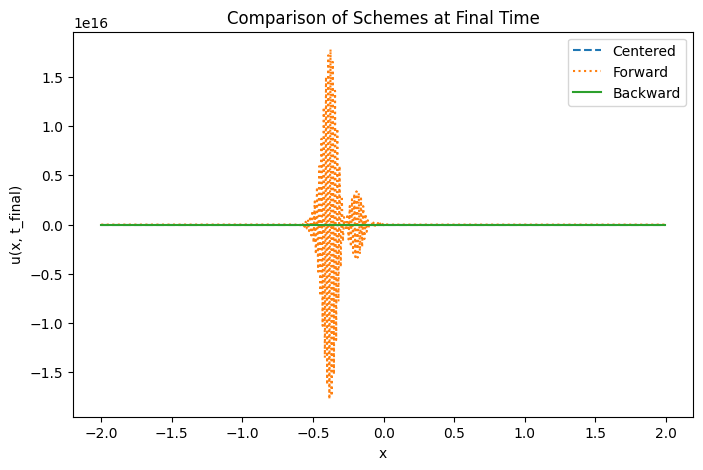

In [164]:
# --- Final states ---
u_c_final = u_c[-1]
u_f_final = u_f[-1]
u_b_final = u_b[-1]

# --- Plot final solutions ---
plt.figure(figsize=(8, 5))
plt.plot(x, u_c_final, label='Centered', linestyle='--')
plt.plot(x, u_f_final, label='Forward', linestyle=':')
plt.plot(x, u_b_final, label='Backward', linestyle='-')
plt.xlabel('x')
plt.ylabel('u(x, t_final)')
plt.title('Comparison of Schemes at Final Time')
plt.legend()
plt.show()

In [165]:
# --- Peak position (where max occurs) ---
def peak_position(u, x):
    return x[np.argmax(u)]

x_peak_c = peak_position(u_c_final, x)
x_peak_f = peak_position(u_f_final, x)
x_peak_b = peak_position(u_b_final, x)

print(f"Peak position (Centered): {x_peak_c:.15f}")
print(f"Peak position (Forward) : {x_peak_f:.15f}")
print(f"Peak position (Backward): {x_peak_b:.15f}")


Peak position (Centered): 0.296000000000000
Peak position (Forward) : -0.376000000000000
Peak position (Backward): 0.296000000000000


## Numerical Convergence Test – 1D Advection Equation

We aim to verify whether our numerical scheme (RK4 in time + centered differences in space) is **convergent**, and estimate its **order of convergence** \( p \).

To do this, we solve the equation using three spatial resolutions: \( N = 125, 250, 500 \), keeping the **CFL** number fixed. We then compare the numerical solutions at the final time by interpolating them to the finest grid and measuring the difference in the \( L^2 \) norm.

The convergence factor is computed as:

\begin{equation}
2^p = \frac{\| u_{\text{low}} - u_{\text{med}} \|_2}{\| u_{\text{med}} - u_{\text{high}} \|_2}
\end{equation}

Which gives the estimated convergence order:

\begin{equation}
p = \log_2\left( \frac{\| u_{\text{low}} - u_{\text{med}} \|_2}{\| u_{\text{med}} - u_{\text{high}} \|_2} \right)
\end{equation}

In [166]:
def advection_simulation(N, tf=0.3, CFL=0.5):
    L = 2.0
    alpha = 1.0 
    d_x = 2*L / N
    x = np.linspace(-L, L, N, endpoint=False)
    dt = CFL * dx / abs(alpha)
    n_steps = int(tf / dt) + 1
    u0 = np.exp(-100 * (x)**2)

    def du_loc(t, u):
        return -alpha * (np.roll(u, -1) - np.roll(u, 1)) / (2 * d_x)

    sol = RK4(du_loc, 0, u0, tf, n_steps)
    return x, sol[-1, 1:]


In [167]:
def plot_convergence_errors(x_ref, u_ref, solutions, labels):
    plt.figure(figsize=(10, 6))
    for (x, u), label in zip(solutions, labels):
        u_interp = interp1d(x, u, kind='cubic', fill_value="extrapolate")(x_ref)
        error = u_interp - u_ref
        plt.plot(x_ref, error, label=f"Error {label}")
    plt.xlabel("x")
    plt.ylabel("Error")
    plt.title("Error relative to N = 2000")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [168]:
def plot_loglog_errors(dxs, errors, title="Log-Log Convergence"):
    plt.figure(figsize=(8, 6))
    plt.loglog(dxs, errors, 'o-', markersize=8, label='L2 error')

    # log adjust
    p_fit = np.polyfit(np.log(dxs), np.log(errors), 1)
    p_est = p_fit[0]

    plt.loglog(
        dxs,
        np.exp(np.polyval(p_fit, np.log(dxs))),
        '--',
        label=f'Fit slope ≈ {p_est:.2f}'
    )

    plt.xlabel(r"$\Delta x$")
    plt.ylabel(r"$L^2$ error")
    plt.title(title)
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Estimated global convergence order (slope): p ≈ {p_est:.2f}")


In [169]:
def analytic_solution(x, t, alpha=1.0, L=2.0):
    x_periodic = (x - alpha * t + L) % (2*L) - L
    return np.exp(-100 * x_periodic**2)

def L2_norm(u1, u2):
    return np.sqrt(np.mean((u1 - u2)**2))


In [170]:

def plot_all_final_states(solutions, resolutions, t, alpha):
    fig, axs = plt.subplots(len(solutions), 1, figsize=(10, 12), sharex=True)
    
    for i, ((xN, uN), N) in enumerate(zip(solutions, resolutions)):
        u_exact = analytic_solution(xN, t, alpha=alpha)
        axs[i].plot(xN, uN, label=f'N = {N}', lw=1.5)
        axs[i].plot(xN, u_exact, '--', label='Exact', lw=1)
        axs[i].set_ylabel('u(x)')
        axs[i].legend(loc='upper right')
        axs[i].grid(True, ls='--', alpha=0.5)
    
    axs[-1].set_xlabel('x')
    fig.suptitle('Final states at t = {:.2f}'.format(t), fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

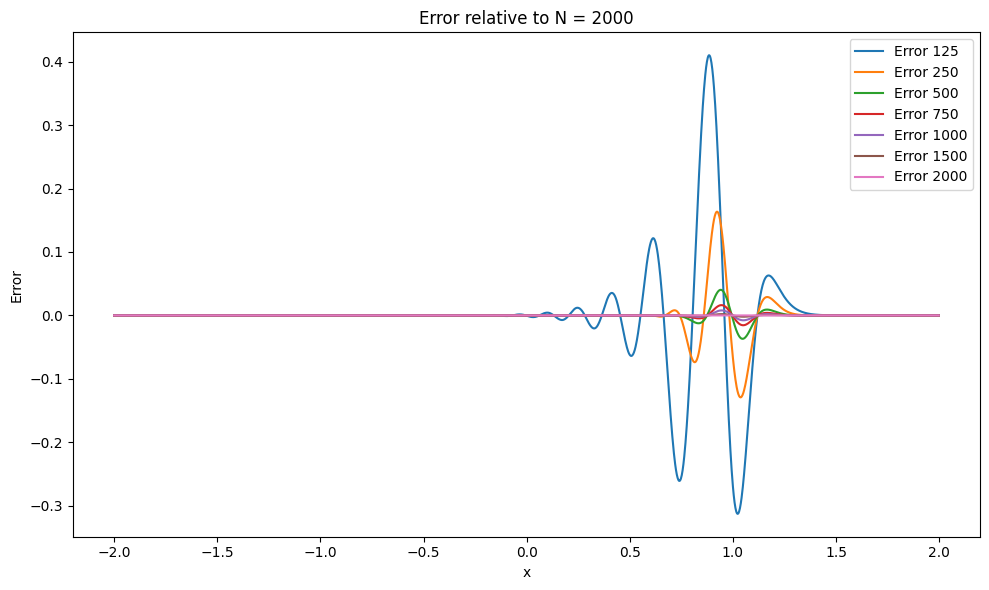

In [171]:
# Running simulations
resolutions = [125, 250, 500, 750, 1000, 1500, 2000]
dxs = [1.0 / N for N in resolutions]

solutions = []
alpha = 1.0
t = 1.0

for N in resolutions:
    xN, uN = advection_simulation(N, tf=t)  
    solutions.append((xN, uN))

# Numeric reference
x_ref, u_ref = solutions[-1]


errors_num = []
errors_exact = []

for i, (xN, uN) in enumerate(solutions):
    # Exact error (compared to analytical solution)
    u_exact = analytic_solution(xN, t, alpha=alpha)
    errors_exact.append(L2_norm(uN, u_exact))
    
    # Numerical error (compared to high-resolution reference)
    if i < len(solutions) - 1:
        u_interp = interp1d(xN, uN, kind='cubic', fill_value="extrapolate")(x_ref)
        errors_num.append(L2_norm(u_interp, u_ref))


labels = [str(N) for N in resolutions]  
labels2 = [str(N) for N in resolutions[:-1]]  


# domain erros
plot_convergence_errors(x_ref, u_ref, solutions, labels)

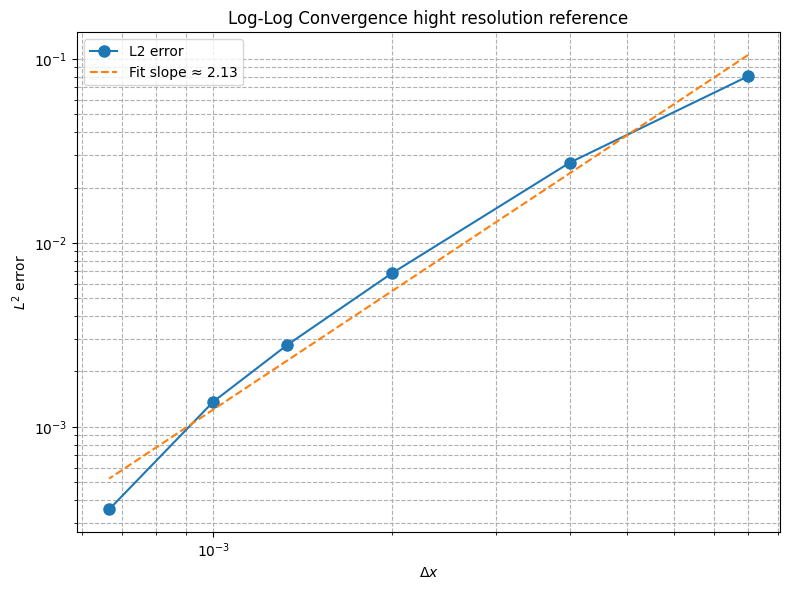

Estimated global convergence order (slope): p ≈ 2.13


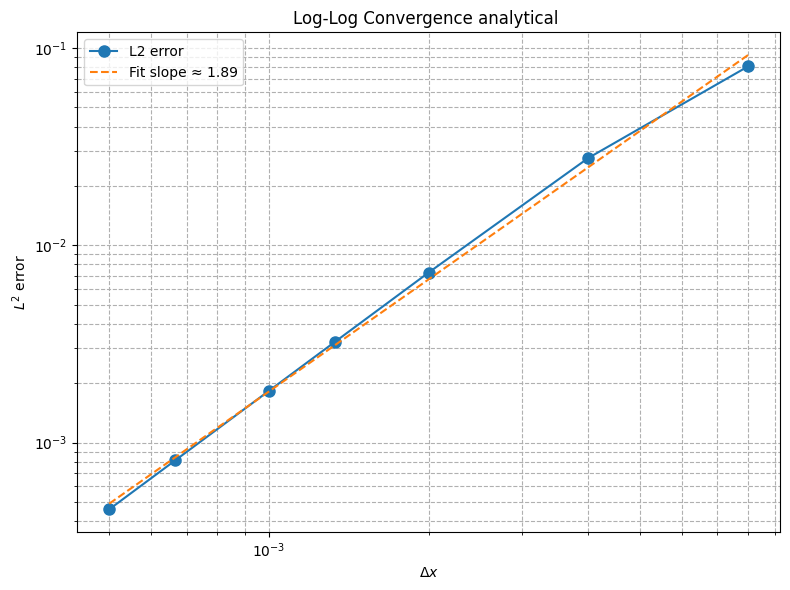

Estimated global convergence order (slope): p ≈ 1.89


In [172]:
plot_loglog_errors(dxs[:-1], errors_num, 
                   title="Log-Log Convergence hight resolution reference")

plot_loglog_errors(dxs, errors_exact,
                    title="Log-Log Convergence analytical ")

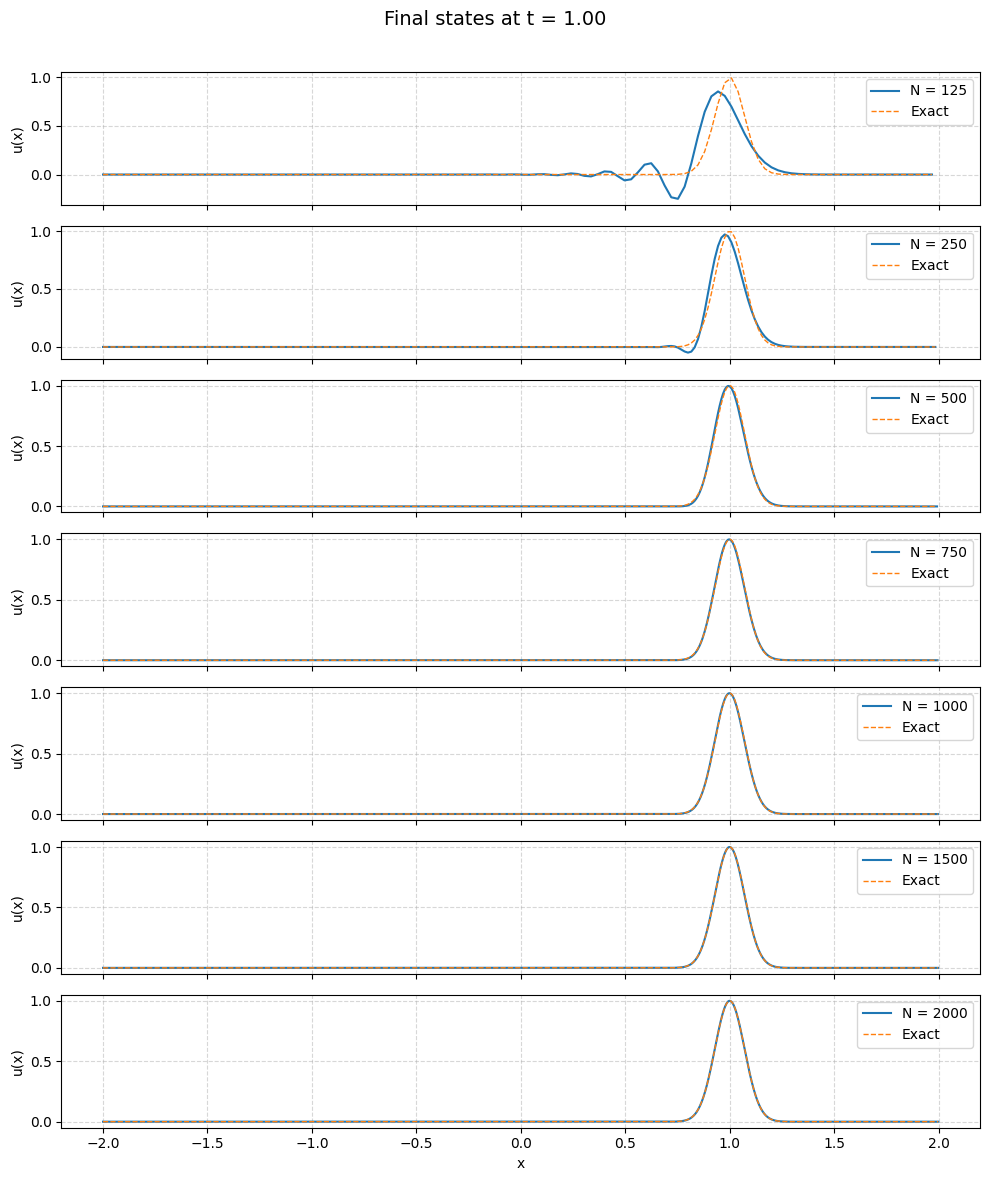

In [173]:

plot_all_final_states(solutions, resolutions, t, alpha)
